This notebook guides you through the ISLES22 data loading, visualization, registeration onto MNI152 brain atlas, and CST load calculation.

In [193]:
!pip install --upgrade pip setuptools
!pip install scipy --ignore-installed
!pip install cmake
!pip install nibabel
!pip install connected-components-3d

615078.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
615085.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
  Using cached scipy-1.11.2.tar.gz (56.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      + meson setup /private/var/folders/_x/d__s93vd5px163_s9lsbkxdw000142/T/pip-install-tf5ft33w/scipy_e304e679640c4ebbb66e74cf53d96d79 /private/var/folders/_x/d__s93vd5px163_s9lsbkxdw000142/T/pip-install-tf5ft33w/scipy_e304e679640c4ebbb66e74cf53d96d79/.mesonpy-8elvr2t6/build -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=/private/var/folders/_x/d__s93vd5px163_s9lsbkxdw000142/T/pip-install-tf5ft33w/scipy_e304e679640c4ebbb66e74cf53d96d79/.mesonpy-8

In [194]:
# imports.
import nibabel as nib
import numpy as np
import os
import ants
import glob
import matplotlib.pyplot as plt
import eval_utils
from os import getcwd
from os import listdir
from os.path import join
import subprocess
import cc3d

In [195]:
# paths.
isles_data_dir = os.path.join(current_dir, 'data/')
xtract_data_dir=os.path.join(current_dir, 'XTRACT_atlases-master/')

#mni152_data_dir='mni152/'
example_case = 9 

# Set images path.
dwi_path = os.path.join(isles_data_dir, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001','dwi',
                    'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" % example_case))
adc_path = os.path.join(isles_data_dir, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001','dwi',
                    'sub-strokecase{}_ses-0001_adc.nii.gz'.format("%04d" % example_case))
flair_path = os.path.join(isles_data_dir, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001','anat',
                    'sub-strokecase{}_ses-0001_FLAIR.nii.gz'.format("%04d" % example_case))
mask_path = os.path.join(isles_data_dir, 'derivatives', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                    'sub-strokecase{}_ses-0001_msk.nii.gz'.format("%04d" % example_case))

In [196]:
# Load image data.
dwi_image = nib.load(dwi_path).get_fdata()
adc_image = nib.load(adc_path).get_fdata()
flair_image = nib.load(flair_path).get_fdata()
mask_image = nib.load(mask_path).get_fdata()

In [197]:
#Registeration
def main_flirt(nii_file_path, ref_file_path, final_nii_output_path, matrix_output_path):
  subprocess.run(['flirt', '-in', nii_file_path, '-ref', ref_file_path, '-out', final_nii_output_path, '-omat', matrix_output_path, '-dof', '6'])
  
def second_flirt(nii_mask_result_file_path, ref_file_path, matrix_output_path, final_nii_output_path):
  subprocess.run(['flirt', '-in', nii_mask_result_file_path, '-ref', ref_file_path, '-applyxfm', '-init', matrix_output_path, '-out', final_nii_output_path])

ref_nii_filename = 'xtract-tract-atlases-maxprob5-1mm.nii.gz'
ref_nii_path = os.path.join(xtract_data_dir, 'fsleyes_atlases/XTRACT', ref_nii_filename)
ref_image = nib.load(ref_nii_path).get_fdata()
reg_dwi_path=os.path.join(isles_data_dir, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001','dwi',
                   'sub-strokecase{}_ses-0001_dwi_reg.nii.gz'.format("%04d" % example_case))
reg_mask_path = os.path.join(isles_data_dir, 'derivatives', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                    'sub-strokecase{}_ses-0001_msk_reg.nii.gz'.format("%04d" % example_case))           
matrix_reg_out=reg_dwi_path.replace('nii', 'mat')
#os.path.exists(reg_dwi_path)
#command = ['flirt', '-in', dwi_path, '-ref', ref_nii_path, '-out', reg_dwi_path, '-omat', matrix_reg_out]
#print("Running command:", " ".join(command))
#subprocess.run(command)

main_flirt(dwi_path, ref_nii_path, reg_dwi_path, matrix_reg_out)

# $work2 using matrix_output_path as input and final_nii_output_path as output
second_flirt(mask_path, ref_nii_path, matrix_reg_out, reg_mask_path)

  
reg_dwi_image = nib.load(reg_dwi_path).get_fdata()
reg_msk_image = nib.load(reg_mask_path).get_fdata()


In [199]:
# Define paths to CST masks - L & R
cst_l_nii_filename = 'cst_l.nii.gz'
cst_r_nii_filename = 'cst_r.nii.gz'
cst_l_nii_path = os.path.join(xtract_data_dir, 'HCP_tracts_5', cst_l_nii_filename)
cst_r_nii_path = os.path.join(xtract_data_dir, 'HCP_tracts_5', cst_r_nii_filename)

# Load the CST NIfTI image and read its header
cst_l_image_load = nib.load(cst_l_nii_path)
# Get the header from the original cst NIfTI image
original_cst_header = cst_l_image_load.header
#print(original_cst_header)

# Read the CST NIfTI image 
cst_l_image = nib.load(cst_l_nii_path).get_fdata()
cst_r_image = nib.load(cst_r_nii_path).get_fdata()

#Multiply the CST masks L and R with the lesion mask to define the junction
CST_lesion_load_L=cst_l_image*reg_msk_image
CST_lesion_load_R=cst_r_image*reg_msk_image



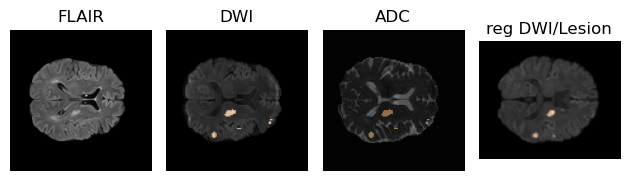

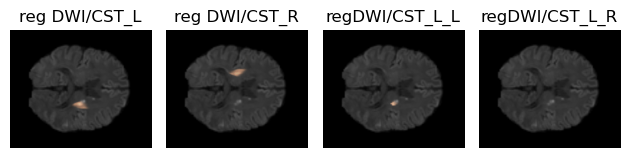

In [201]:
# Visualize the MR images with their corresponding mask overlays.

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

# Show FLAIR image.
ax1.imshow(flair_image[:,:,16], cmap='gray')
ax1.set_title('FLAIR')
ax1.set_axis_off()

slice2show=40
# Show DWI image w/overlayed mask.
ax2.imshow(dwi_image[:,:,slice2show], cmap='gray')
ax2.imshow(mask_image[:,:,slice2show], alpha=0.5, cmap='copper')
ax2.set_title('DWI')
ax2.set_axis_off()

# Show ADC image w/overlayed mask.
ax3.imshow(adc_image[:,:,slice2show], cmap='gray')
ax3.imshow(mask_image[:,:,slice2show], alpha=0.5, cmap='copper')
ax3.set_title('ADC')
ax3.set_axis_off()

slice2show=94
# Show registered DWI image w/overlayed registered mask.
ax4.imshow(reg_dwi_image[:,:,slice2show], cmap='gray')
ax4.imshow(reg_msk_image[:,:,slice2show], alpha=0.5, cmap='copper')
ax4.set_title('reg DWI/Lesion')
ax4.set_axis_off()

plt.tight_layout()
plt.show()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)


# Show registered DWI image w/overlayed CST_L mask.
ax1.imshow(reg_dwi_image[:,:,slice2show], cmap='gray')
ax1.imshow(cst_l_image[:,:,slice2show], alpha=0.5, cmap='copper')
ax1.set_title('reg DWI/CST_L')
ax1.set_axis_off()

# Show registered DWI image w/overlayed CST_R mask.
ax2.imshow(reg_dwi_image[:,:,slice2show], cmap='gray')
ax2.imshow(cst_r_image[:,:,slice2show], alpha=0.5, cmap='copper')
ax2.set_title('reg DWI/CST_R')
ax2.set_axis_off()

# Show registered DWI image w/overlayed CST lesion load L mask.
ax3.imshow(reg_dwi_image[:,:,slice2show], cmap='gray')
ax3.imshow(CST_lesion_load_L[:,:,slice2show], alpha=0.5, cmap='copper')
ax3.set_title('regDWI/CST_L_L')
ax3.set_axis_off()

# Show registered DWI image w/overlayed CST lesion load R mask.
ax4.imshow(reg_dwi_image[:,:,slice2show], cmap='gray')
ax4.imshow(CST_lesion_load_R[:,:,slice2show], alpha=0.5, cmap='copper')
ax4.set_title('regDWI/CST_L_R')
ax4.set_axis_off()


plt.tight_layout()
plt.show()

In [203]:
# Calculate the number of pixels within the whole lesion, and within the lesion overlapped with the CST
lesion_msk_bool = np.asarray(mask_image).astype(bool)
CST_lesion_L_msk_bool = np.asarray(CST_lesion_load_L).astype(bool)
CST_lesion_R_msk_bool = np.asarray(CST_lesion_load_R).astype(bool)

# Define the connectivity for connected components (e.g., 6 for 3D 6-connectivity)
connectivity = 6

_, mask_numb_lesion = cc3d.connected_components(lesion_msk_bool, connectivity=connectivity, return_N=True)
_, CST_L_numb_lesion = cc3d.connected_components(CST_lesion_L_msk_bool, connectivity=connectivity, return_N=True)
_, CST_R_numb_lesion = cc3d.connected_components(CST_lesion_R_msk_bool, connectivity=connectivity, return_N=True)

#abs_les_diff = abs(mask_numb_lesion - CST_L_numb_lesion)

orig_voxel_volume = np.prod(nib.load(dwi_path).header.get_zooms())/1000 # Get original voxel volume
reg_voxel_volume = np.prod(nib.load(ref_nii_path).header.get_zooms())/1000 # Get original voxel volume

orig_voxel_volume = orig_voxel_volume.astype(float)
reg_voxel_volume = reg_voxel_volume.astype(float)

#Calculate lesion volumes within the masks
lesion_mask_volume = np.sum(lesion_msk_bool) * orig_voxel_volume
CST_lesion_L_mask_volume = np.sum(CST_lesion_L_msk_bool) * reg_voxel_volume
CST_lesion_R_mask_volume = np.sum(CST_lesion_R_msk_bool) * reg_voxel_volume
Total_CST_lesion_mask_volume= CST_lesion_L_mask_volume+CST_lesion_R_mask_volume
abs_vol_diff = np.abs(lesion_mask_volume - Total_CST_lesion_mask_volume)

print('Lesion volume : ', format(lesion_mask_volume, ".2f"), 'ml')
print('CST Lesion L volume : ', format(CST_lesion_L_mask_volume, ".2f"), 'ml')
print('CST Lesion R volume : ', format(CST_lesion_R_mask_volume, ".2f"), 'ml')
print('Total CST Lesion load : ', format(Total_CST_lesion_mask_volume, ".2f"), 'ml')
perc_CSTlesionload=Total_CST_lesion_mask_volume/lesion_mask_volume*100
print('Total CST lesion load percentage within lesion volume : ', format(perc_CSTlesionload, ".2f"), '%')


# Assuming you have the same header as your original cst image
# Extract the affine matrix from the header
affine_matrix = original_cst_header.get_qform()


new_nifti_img_CST_L = nib.Nifti1Image(CST_lesion_load_L, affine_matrix)
new_nifti_img_CST_R = nib.Nifti1Image(CST_lesion_load_R, affine_matrix)
# Save the NIfTI image to a file
output_filename = 'CST_lesion_L.nii.gz'
nib.save(new_nifti_img_CST_L, output_filename)
output_filename = 'CST_lesion_R.nii.gz'
nib.save(new_nifti_img_CST_R, output_filename)


Lesion volume :  4.18 ml
CST Lesion L volume :  2.94 ml
CST Lesion R volume :  0.00 ml
Total CST Lesion load :  2.94 ml
Total CST lesion load percentage within lesion volume :  70.20 %
